In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

<font color='cyan'>**Ejercicio #1**</font> <br><br>
Usando **smooth_if** implementar **smooth_max(x,y)** de forma diferenciable. 
***

In [ ]:
def smooth_if(cond, a, b, alpha = 100):

    '''retorna a si cond > 0, sino retorna b'''
    
    sigmoid = torch.sigmoid(alpha * cond)
    return sigmoid * a + (1 - sigmoid) * b

In [ ]:
def smooth_max(x, y):
    return smooth_if( ... ) # <---- COMPLETAR

In [ ]:
def smooth_max(x, y):
    return smooth_if(x - y, x, y)                       # SOLUCION --- SACAR

In [ ]:
x = torch.tensor(3., requires_grad = True)
y = torch.tensor(2., requires_grad = True)

smooth_max(x, y)

<font color='cyan'>**Ejercicio #2**</font> <br><br>
Usando las funciones que ya vimos, implementar **selection sort** diferenciable
***

In [ ]:
def smooth_max(v, alpha = 100):                      # a modo de referencia, no hay que usar max 
    weights = torch.softmax(alpha * v, dim = 0)
    return (weights * v).sum()

def smooth_min(v, alpha = 100):                                    
    weights = torch.softmax( ... , dim = 0)     # <---- COMPLETAR
    return (weights * v).sum()

def smooth_argmin(v, alpha = 100):
    
    # COMPLETAR : la función debe devolver un tensor que se aproxime de forma diferenciable a [0, 0, ... , 1 , ... 0] 
    # donde el 1 indica la posición en 'v' dónde se encuentra el mínimo. PISTA: es muy parecido a smooth_min

    return 0

In [ ]:
def smooth_min(v, alpha = 100):                                    # SACAR RESUELTOS <------------
    weights = torch.softmax(-alpha * v, dim = 0)
    return (weights * v).sum()

def smooth_argmin(v, alpha = 100):
    weights = torch.softmax(-alpha * v, dim = 0)
    return weights

In [ ]:
def smooth_sort(u):

    size = u.size(dim=0)

    for i in range(size):
        
        min = ...                                                       # COMPLETAR : valor mínimo en u[i:]
        argmin = torch.cat((torch.zeros(i), ... ))                      # COMPLETAR : indice del valor mínimo en u[i:]

        # Smooth swap 

        u_temp = u.clone()  
        u_temp = u_temp - argmin * u_temp 

        u0 = u_temp[i].clone()
        u_temp[i] = min  

        u = u_temp + argmin * u0 

    return u

In [ ]:
def smooth_sort(u):                                                                # SACAR SOLUCIONNNN

    size = u.size(dim=0)

    for i in range(size):
        
        min = smooth_min(u[i:])  
        argmin = torch.cat((torch.zeros(i), smooth_argmin(u[i:])))

        # Smooth swap 

        u_temp = u.clone()  
        u_temp = u_temp - argmin * u_temp 

        u0 = u_temp[i].clone()
        u_temp[i] = min  

        u = u_temp + argmin * u0 

    return u

In [ ]:
# OJO, no puede haber repetidos en s

s = torch.tensor([10,5,2,3,98,100,0], dtype = torch.float, requires_grad = True)
smooth_sort(s)

**Aplicación: optimizar la diferencia entre el primer y último elemento luego de ser ordenado el tensor**

In [ ]:
s = torch.tensor([4,3,2,1], dtype = torch.float, requires_grad = True)

optimizer = torch.optim.Adam([s], lr = 0.1)

for epoch in range(41):

    optimizer.zero_grad()
    sorted = smooth_sort(s)

    y = (sorted[0] - sorted[-1]) ** 2

    y.backward()
    optimizer.step()

    if epoch % 5 == 0: print("epoch", epoch, y, s)

In [ ]:
t = s.clone()
print("Antes del Sorting: ", (t[0] - t[-1]) ** 2)

t_sort = smooth_sort(t)
print("Despues del Sorting: ", (t_sort[0] - t_sort[-1]) ** 2)

<font color='cyan'>**Ejercicio #3 : Círculo Diferenciable**</font> <br><br>
Completar la función **circle**
***

In [ ]:
def distance(x, y, center):
    
    '''computa la distancia euclidea (diferenciable) de (x,y) al centro'''

    distance = torch.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    return distance

In [ ]:
def circle(x, y, center, radius, alpha = 100):                                  

    '''devuelve 1.0 si (x,y) está dentro del círculo y 0.0 si está fuera'''

    d = ...                         # COMPLETAR : distancia al centro 
    return ...                      # COMPLETAR 

In [ ]:
def circle(x, y, center, radius, alpha = 100):                                  # SOLUCION SACAR <---

    '''devuelve 1.0 si (x,y) está dentro del círculo y 0.0 si está fuera'''

    d = distance(x, y, center)
    return smooth_if(d - radius, 0.0, 1.0, alpha)

In [ ]:
x, y = torch.meshgrid(torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100))

center = torch.tensor([0.0, 0.0], requires_grad = True)  
radius = torch.tensor(0.5, requires_grad = True)  

In [ ]:
image = circle(x, y, center, radius, alpha = 100)

In [ ]:
plt.imshow(image.detach().numpy(), cmap = "hot")
plt.colorbar()

**Aplicación : Optimización de la suma de la imagen**

In [ ]:
x, y = torch.meshgrid(torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100))

center = torch.tensor([0.0, 0.0], requires_grad = True)  
radius = torch.tensor(0.5, requires_grad = True)  

optimizer = torch.optim.Adam([center, radius], lr = 0.01)

for epoch in range(61):

    optimizer.zero_grad()

    image = circle(x, y, center, radius, alpha = 100)

    image.sum().backward()
    optimizer.step()

    if epoch % 10 == 0: 
        
        plt.figure(figsize=(3,3))

        plt.imshow(image.detach().numpy(), cmap = "hot")
        plt.show()

        print("epoch", epoch, image.sum())

**Aplicación : Ellipse Splatting**
***

In [ ]:
def ellipse(x, y, center, radius_x, radius_y, alpha):

    '''Devuelve la distancia de (x, y) al borde de la elipse centrada en `center` con radios `radius_x` y `radius_y`.'''
    
    # Coordenadas relativas al centro
    rel_x = x - center[0]
    rel_y = y - center[1]
    
    # Distancia elíptica ajustada
    d = torch.sqrt((rel_x / radius_x) ** 2 + (rel_y / radius_y) ** 2)
    
    # Si `d` es mayor que 1, el punto está fuera de la elipse, y la distancia es proporcional al borde
    # Si `d` es menor o igual a 1, el punto está dentro de la elipse, y la distancia es 0

    return smooth_if(d - 1, 0.0, 1.0, alpha)

In [158]:
x, y = torch.meshgrid(torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100))

n = 10

center = torch.rand((n,2), requires_grad = True)  
with torch.no_grad(): center = center * 2 - 1

radius_x = torch.rand((n), requires_grad = True) 
radius_y = torch.rand((n), requires_grad = True) 
color = torch.rand((n), requires_grad = True)
alpha = torch.rand((n), requires_grad= True)

In [164]:
layers = torch.zeros((n, 100, 100))

for i in range(n):
    layers[i] = ellipse(x, y, center[i], radius_x[i], radius_y[i], alpha[i] * 10)

image = layers.sum(dim=0)

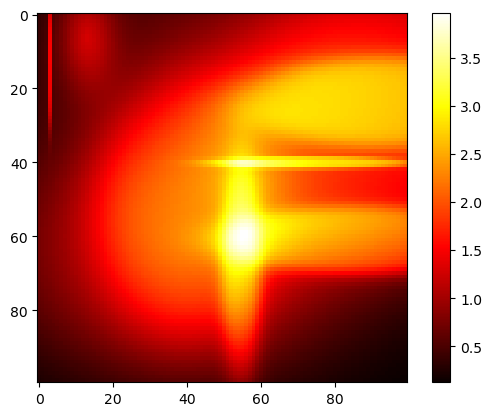

In [165]:
plt.imshow(image.detach().numpy(), cmap = "hot")
plt.colorbar()

**Optimización : Ellipse Splatting**
***

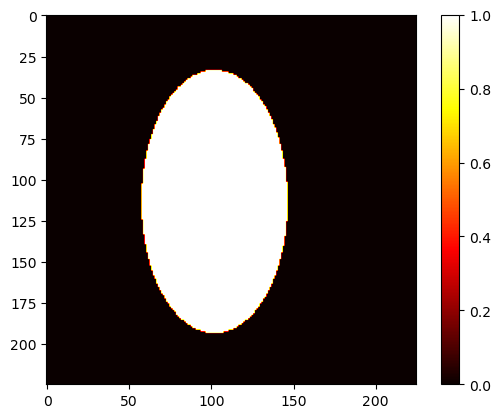

In [182]:
image = plt.imread("images/ellipse.png")
gt_image = torch.tensor(image[:,:,0])

plt.imshow(gt_image, cmap = "hot")
plt.colorbar()

In [198]:
size = 225
n = 1

x, y = torch.meshgrid(torch.linspace(-1, 1, size), torch.linspace(-1, 1, size))

center = torch.rand((n,2), requires_grad = True)
with torch.no_grad(): center = center * 2 - 1

radius_x = torch.ones((n), requires_grad = True) 
radius_y = torch.ones((n), requires_grad = True) 

with torch.no_grad(): 

    radius_x *= 0.5
    radius_y *= 0.5

alpha = torch.rand((n), requires_grad= True)

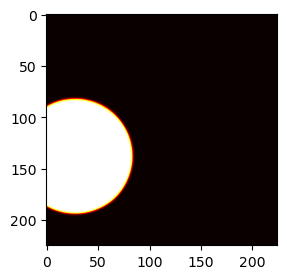

epoch 0 tensor(0.3210, grad_fn=<MseLossBackward0>)


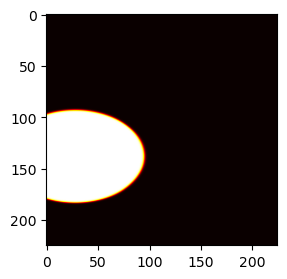

epoch 100 tensor(0.2879, grad_fn=<MseLossBackward0>)


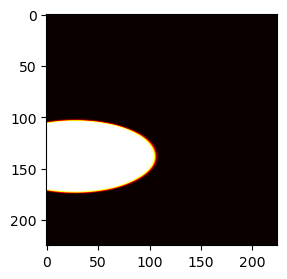

epoch 200 tensor(0.2614, grad_fn=<MseLossBackward0>)


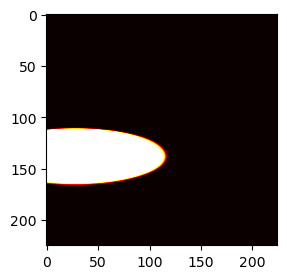

epoch 300 tensor(0.2437, grad_fn=<MseLossBackward0>)


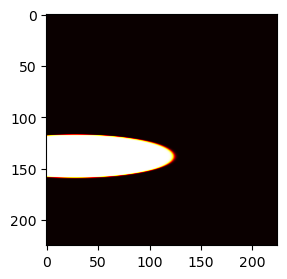

epoch 400 tensor(0.2328, grad_fn=<MseLossBackward0>)


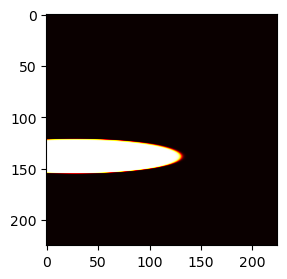

epoch 500 tensor(0.2267, grad_fn=<MseLossBackward0>)


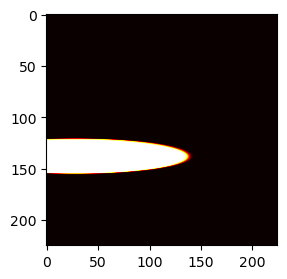

epoch 600 tensor(0.2230, grad_fn=<MseLossBackward0>)


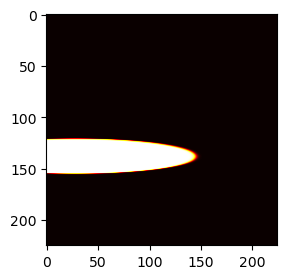

epoch 700 tensor(0.2196, grad_fn=<MseLossBackward0>)


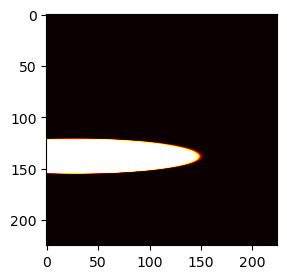

epoch 800 tensor(0.2185, grad_fn=<MseLossBackward0>)


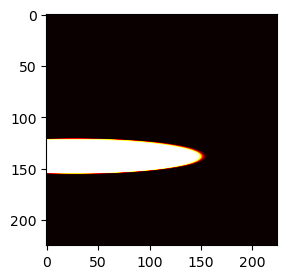

epoch 900 tensor(0.2183, grad_fn=<MseLossBackward0>)


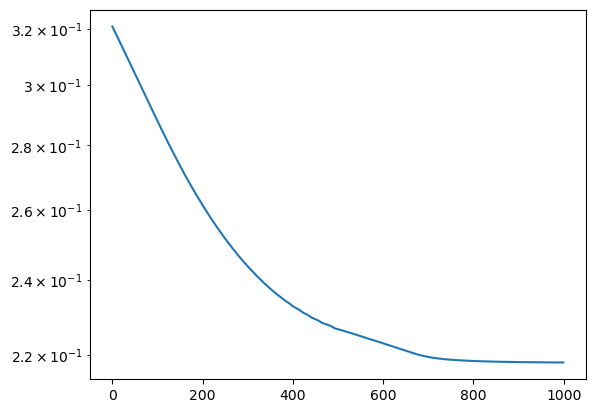

In [199]:
losses = []
optimizer = torch.optim.Adam([center, radius_x, radius_y, alpha], lr = 0.001)

for epoch in range(1000):

    layers = torch.zeros((n, size, size))

    optimizer.zero_grad()

    for i in range(n):
        layers[i] = ellipse(x, y, center[i], radius_x[i], radius_y[i], 100)

    image = torch.sum(layers, dim = 0)

    loss = F.mse_loss(image, gt_image)
    loss.backward()
    losses.append(loss.item())

    optimizer.step()

    if epoch % 100 == 0: 
        plt.figure(figsize=(3,3))

        plt.imshow(image.detach().numpy(), cmap = "hot")
        plt.show()
        print("epoch", epoch, loss)

plt.plot(losses)
plt.yscale('log')        

***

In [200]:
def sdf_circle(x, y, center, radius):

    '''Computa la distancia a la superficie del círculo'''

    return distance(x, y, center) - radius

In [209]:
center = torch.tensor([0,0], dtype = torch.float, requires_grad = True)
center2 = torch.tensor([0.3,0.3], dtype = torch.float, requires_grad = True)

d = torch.min(sdf_circle(x, y, center, 0.2), sdf_circle(x, y, center2, 0.5))
image = smooth_if(d, 0.0, 1.0)

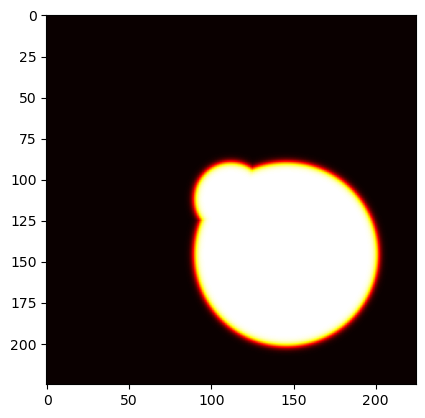

In [210]:
plt.imshow(image.detach().numpy(), cmap = "hot")